In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import math
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()

from matplotlib import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
number = LabelEncoder()
from statsmodels.stats.outliers_influence import summary_table
from adjustText import adjust_text
from collections import OrderedDict

# Adjust css for usability
from IPython.core.display import HTML
HTML('''
<style type="text/css">

.jp-RenderedHTMLCommon table {
    table-layout: auto;
    border-collapse: collapse;
    width: 75%;
}

.jp-RenderedHTMLCommon table .absorbing-column {
    width: 75%;
}

</style>
''')

# CONSTANTS

markerSymbol = [
    "o", #circle
    "v", #triangle_down
    "^", #triangle_up
    "<", #triangle_left
    ">", #triangle_right
    "s", #square
    "p", #pentagon
    "P", #plus (filled)
    "*", #star
    "H", #hexagon2
    "X", #x (filled)
    "D", #diamond
    "d", #thin_diamond
    "1", #tri_down
    "2", #tri_up
    "3", #tri_left
    "4", #tri_right
    "+", #plus
    "x"  #x
];

markerColour = [
    '#b71c1c', #red darken-4
    '#1a237e', #indigo darken-4
    '#004d40', #teal darken-4
    '#f57f17', #yellow darken-4
    '#3e2723', #brown darken-4    
    '#4a148c', #purple darken-4
    '#01579b', #light-blue darken-4
    '#33691e', #light-green darken-4
    '#e65100', #orange darken-4
    '#263238', #blue-grey darken-4
    '#880e4f', #pink darken-4
    '#0d47a1', #blue darken-4
    '#1b5e20', #green darken-4
    '#ff6f00', #amber darken-4
    '#212121', #grey darken-4
    '#311b92', #deep-purple darken-4
    '#006064', #cyan darken-4
    '#827717', #lime darken-4
    '#bf360c'  #deep-orange darken-4
];

## Function to scatter plot

In [2]:
# GET THE MAGNITUDE ORDER OF A NUMBER
def magnitude(value):
    try:
        return 10**(int(math.floor(math.log10(abs(value)))))
    except:
        return 0
    
# min val in array w/empty array fix
def cmin(value):
    try:
        return np.nanmin(value)
    except:
        return float('NaN')
    
def cmax(value):
    try:
        return np.nanmax(value)
    except:
        return float('NaN')

In [3]:
# # SIMPLE SCATTER PLOT OF TWO VARIABLES
# def scatterPlot(x_str, x_units, y_str, y_units, df, fig_name):
#     # PLOT FIG
#     scale = 6;
#     fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

#     # sort values by the independent variable
#     df_x = df.sort_values(by=[x_str])
#     # remove NANs from both variables and store them
#     df_x = df_x.dropna(subset=[x_str, y_str])
#     x = df_x.iloc[:][x_str]
#     y = df_x.iloc[:][y_str]

#     # Plot
#     plt.scatter(x, y, s=25)
    
#     # Display plots
#     plt.yscale('linear');
#     plt.xlabel(x_str + '    ' + x_units, fontsize=24);
#     plt.ylabel(y_str + '    ' + y_units, fontsize=24);
#     plt.title(fig_name, size=24);
#     #plt.legend(prop={'size': 18});
#     #plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
#     plt.show();

In [4]:
# SCATTER PLOT WITH AXIS-BREAK AND REFERENCE ANNOTATIONS
def scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim=None, breakYlim=None, legloc='best'):
    ''' <required> x_str          : x-axis name. Must match a column name within df and df_x
    
        <required> x_units        : String used to print the x-axis units
        
        <required> y_str          : y-axis name. Must match a column name within df and df_x
        
        <required> y_units        : String used to print the y-axis units
        
        <required> df             : raw dataframe structure usually obtained from a CSV file
        
        <required> df_x           : Same as df, but string values shall be replaced with some
                                    representative integer values
        
        <optional> breakXlim=None : Specifies the x value where to break the x-axis range
                                   
        <optional> breakYlim=None : Specifies the y value where to break the y-axis range
                                
        <optional> legloc='best'  : Specifies the legend box location. It can be:
                                    |-------------------+---------------|
                                    | Location String   | Location Code |
                                    |-------------------+---------------|
                                    | 'best'            |  0            |
                                    | 'upper right'     |  1            |
                                    | 'upper left'      |  2            |
                                    | 'lower left'      |  3            |
                                    | 'lower right'     |  4            |
                                    | 'right'           |  5            |
                                    | 'center left'     |  6            |
                                    | 'center right'    |  7            |
                                    | 'lower center'    |  8            |
                                    | 'upper center'    |  9            |
                                    | 'center'          | 10            |
                                    |-------------------+---------------|'''
    
    # GET THE X Y VALUES
    # remove NANs from both variables and store them
    df_xx = df_x.dropna(subset=[x_str, y_str]);
    x     = df_xx.iloc[:][x_str];
    y     = df_xx.iloc[:][y_str];

    # GET THE REFERENCE STRING VALUES FOR PLOT ANNOTATIONS
    ref           = df.iloc[:]['Reference'];
    polymerName   = df.iloc[:]['Polymer'];
    polymerColour = df_xx.iloc[:]['Polymer'];

    # CREATE A NEW DATAFRAME WITH THE INTERESTING DATA ONLY
    # IN ORDER TO EFFECTIVELY REMOVE DUPLICATES
    new_df = pd.DataFrame(x);
    new_df = new_df.join(pd.DataFrame(y));
    new_df = new_df.join(pd.DataFrame(ref));
    new_df = new_df.join(pd.DataFrame(polymerColour));
    new_df = new_df.join(pd.DataFrame(polymerName).rename(columns={"Polymer": "Polymer Name"}));

    # Drop duplicate values 
    new_df = new_df.drop_duplicates(subset=new_df.columns.difference(['Polymer', 'Polymer Name']));

    # Extract the interesting data frame into individual
    # panda series
    x         = new_df.iloc[:][x_str];
    y         = new_df.iloc[:][y_str];
    ref       = new_df.iloc[:]['Reference'];
    polName   = new_df.iloc[:]['Polymer Name'];
    polColour = new_df.iloc[:]['Polymer'];
        
    # PLOT SETUP
    scale = 6;
    fig   = plt.figure(figsize=(3*scale, 2*scale));
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.tight_layout();
    
    noTicksIf1point = 3;
    
    # LET'S CHOOSE HOW TO BREAK THE PLOT
    if (breakXlim == None and breakYlim != None): #only break the y-axis
        # Implement a 3rows-1column grid to plot an "axis break"
        # SMALL TOP - BIG BOTTOM
        grid = plt.GridSpec(3, 1, wspace=0.4);
        ax0  = fig.add_subplot(grid[ 0, 0]); # TOP part
        ax1  = fig.add_subplot(grid[1:, 0]); # BOTTOM part

        # Use breakYlim to split the data and plot accordingly on each subplot
        # Plot each point individually to give each a defined color according to its related polymer
        '''
        +------------------------+
        | ax0 : >ylim            |
        +------------------------+
        | ax1 : <ylim  (or else) |
        +------------------------+
        '''
        ax0_data_y = [];
        ax1_data_y = [];
        for xi, yi, ci, ni in zip(x, y, polColour, polName):
            if (yi > breakYlim):
                ax0_data_y.append(yi);
                ax0.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
            else:
                ax1_data_y.append(yi);
                ax1.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
                
        # ZOOM-IN AND LIMIT THE VIEW TO DIFFERENT PORTIONS OF THE DATA
        dy_b = magnitude(np.nanmean(ax1_data_y)); dy_t = magnitude(np.nanmean(ax0_data_y));
        dx   = magnitude(np.mean(x));

        # same xy-axis limits for all subplots to be consistent with scaling
        # y-limits        
        ax0.set_ylim(int(cmin(ax0_data_y)-dy_t), int(cmax(ax0_data_y)+dy_t));
        ax1.set_ylim(int(cmin(ax1_data_y)-dy_b), int(cmax(ax1_data_y)+dy_b));
        # x-limits
        ax0.set_xlim(int(cmin(x)-dx), int(cmax(x)+dx));
        ax1.set_xlim(int(cmin(x)-dx), int(cmax(x)+dx));

        # hide the spines and axis between ax0 and ax1
        ax0.yaxis.get_major_ticks()[1].label1.set_visible(False);
        ax0.spines['bottom'].set_visible(False);
        ax0.axes.get_xaxis().set_visible(False);
        ax1.spines['top'].set_visible(False);
        ax1.xaxis.tick_bottom();

        # remove sci notation
        ax1.ticklabel_format(useOffset=False);
        ax0.ticklabel_format(useOffset=False);
        
        # limit the no. of ticks to 2 if only one point exists
        if (len(ax0_data_y)<2) : ax0.yaxis.set_major_locator(plt.MaxNLocator(noTicksIf1point));
        if (len(ax1_data_y)<2) : ax1.yaxis.set_major_locator(plt.MaxNLocator(noTicksIf1point));
        
        # ensure y-axis tick continuous enumeration
        x1labels = ax1.get_yticks().astype(int).tolist()
        x0labels = ax0.get_yticks().astype(int).tolist()
        for i in range(len(x0labels)):
            if (x1labels[-1] > x0labels[i]) : x0labels[i]='';
        ax0.set_yticklabels(x0labels)
        
        # FORMAT THE AXIS BREAK GRAPHICS
        d  = .0075; # how big to make the diagonal lines in axes coordinates
        d0 = d*2;  # add some offset to have the same inclination on all diagonals
        
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False);
        # draw top-left diagonal
        ax0.plot((0-d, 0+d), (0-d0, 0+d0), **kwargs);
        # draw top-right diagonal
        ax0.plot((1-d, 1+d), (0-d0, 0+d0), **kwargs);
        
        kwargs.update(transform=ax1.transAxes, color='k', clip_on=False);  # switch to the bottom axes
        # draw bottom-left diagonal
        ax1.plot((0-d, 0+d), (1-d, 1+d), **kwargs);
        # draw bottom-right diagonal
        ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs);

        # Vary the distance between ax0 and ax1
        fig.subplots_adjust(hspace=0.1);

        # GROUP ALL SUBPLOTS TO ADD FURTHER FORMATTING
        # add a big axis to group all, and hide its frame
        main = fig.add_subplot(111, frameon=False);
        # hide tick and tick label of the big axis
        plt.ylim(x1labels[0], x0labels[-1]) # set the ylim to bottom, top
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, labelsize=15);

        # Display plots
        # add annotations (references on each point)
        texts_ax0 = [];
        texts_ax1 = [];
        for xs, ys, ss in zip(x, y, ref):
            if (ys > breakYlim):
                texts_ax0.append(ax0.text(xs, ys, str(ss), fontsize=15));
            else:
                texts_ax1.append(ax1.text(xs, ys, str(ss), fontsize=15));
        # avoid overlaps between annotations and add a linking line
        kwargs = dict(transform=ax0.transAxes);
        adjust_text(texts_ax0, ax=ax0, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs);
        kwargs = dict(transform=ax1.transAxes);
        adjust_text(texts_ax1, ax=ax1, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs);

        # Show the plot lengend to link colors and polymer names
        handles0, labels0 = ax0.get_legend_handles_labels();
        handles1, labels1 = ax1.get_legend_handles_labels();
        lgd = dict(zip(labels0+labels1, handles0+handles1));
    
    elif (breakXlim != None and breakYlim == None): #only break the x-axis
        # Implement a 1row-3columns grid to plot an "axis break"
        # SMALL TOP - BIG BOTTOM
        grid = plt.GridSpec(1, 3, wspace=0.05)
        ax0  = fig.add_subplot(grid[0, :-1]); # LEFT part
        ax1  = fig.add_subplot(grid[0, -1]);  # RIGHT part

        # Use breakYlim to split the data and plot accordingly on each subplot
        # Plot each point individually to give each a defined color according to its related polymer
        '''
        +------------------------+--------------+
        | ax0 : <xlim  (or else) |  ax1 : >xlim |
        +------------------------+--------------+
        '''
        ax1_data_x = [];
        ax0_data_x = [];
        for xi, yi, ci, ni in zip(x, y, polColour, polName):
            if (xi > breakXlim):
                ax1_data_x.append(xi);
                ax1.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
            else:
                ax0_data_x.append(xi);
                ax0.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
                
        # ZOOM-IN AND LIMIT THE VIEW TO DIFFERENT PORTIONS OF THE DATA
        dx_l = magnitude(np.nanmean(ax0_data_x)); dx_r = magnitude(np.nanmean(ax1_data_x));
        dy   = magnitude(np.mean(y));

        # same xy-axis limits for all subplots to be consistent with scaling
        # x-limits
        ax0.set_ylim(int(cmin(ax0_data_x)-dx_l), int(cmax(ax0_data_x)+dx_l));
        ax1.set_ylim(int(cmin(ax1_data_x)-dx_r), int(cmax(ax1_data_x)+dx_r));
        # y-limits
        ax0.set_ylim(int(cmin(y)-dy), int(cmax(y)+dy));
        ax1.set_ylim(int(cmin(y)-dy), int(cmax(y)+dy));
        
        # hide the spines and axis between ax0 and ax1
        ax1.xaxis.get_major_ticks()[1].label1.set_visible(False);
        ax1.spines['left'].set_visible(False);
        ax1.axes.get_yaxis().set_visible(False);
        ax0.spines['right'].set_visible(False);
        
        # remove sci notation
        ax1.ticklabel_format(useOffset=False);
        ax0.ticklabel_format(useOffset=False);
        
        # limit the no. of ticks to 2 if only one point exists
        if (len(ax0_data_x)<2) : ax0.xaxis.set_major_locator(plt.MaxNLocator(noTicksIf1point));
        if (len(ax1_data_x)<2) : ax1.xaxis.set_major_locator(plt.MaxNLocator(noTicksIf1point));
            
        # ensure x-axis tick continuous enumeration
        x0labels = ax0.get_xticks().astype(int).tolist()
        x1labels = ax1.get_xticks().astype(int).tolist()
        for i in range(len(x1labels)):
            if (x0labels[-1] > x1labels[i]) : x1labels[i]='';
        ax1.set_xticklabels(x1labels)
        
        # FORMAT THE AXIS BREAK GRAPHICS
        d  = .0075; # how big to make the diagonal lines in axes coordinates
        d0 = d*2;  # add some offset to have the same inclination on all diagonals
        
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False);
        # draw bottom-left diagonal
        ax0.plot((1-d, 1+d), (0-d0, 0+d0), **kwargs);
        # draw top-left diagonal
        ax0.plot((1-d, 1+d), (1-d0, 1+d0), **kwargs);
        
        kwargs.update(transform=ax1.transAxes, color='k', clip_on=False);  # switch to the right axes
        # draw top-right diagonal
        ax1.plot((0-d0, 0+d0), (1-d0, 1+d0), **kwargs);
        # draw bottom-right diagonal
        ax1.plot((0-d0, 0+d0), (0-d0, 0+d0), **kwargs);
        
        # Vary the distance between ax0 and ax1
        fig.subplots_adjust(hspace=0.1);
        
        # GROUP ALL SUBPLOTS TO ADD FURTHER FORMATTING
        # add a big axis to group all, and hide its frame
        main = fig.add_subplot(111, frameon=False);
        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False);
        
        # Display plots
        # add annotations (references on each point)
        texts_ax1 = [];
        texts_ax0 = [];
        for xs, ys, ss in zip(x, y, ref):
            if (xs > breakXlim):
                texts_ax1.append(ax1.text(xs, ys, str(ss), fontsize=15));
            else:
                texts_ax0.append(ax0.text(xs, ys, str(ss), fontsize=15));
        # avoid overlaps between annotations and add a linking line
        kwargs = dict(transform=ax0.transAxes);
        adjust_text(texts_ax0, ax=ax0, arrowprops=dict(arrowstyle="-", color='k', lw=0.1), save_steps=False, **kwargs);
        kwargs = dict(transform=ax1.transAxes);
        adjust_text(texts_ax1, ax=ax1, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs);
        
        # Show the plot lengend to link colors and polymer names
        handles0, labels0 = ax0.get_legend_handles_labels();
        handles1, labels1 = ax1.get_legend_handles_labels();
        lgd = dict(zip(labels0+labels1, handles0+handles1));
    
    elif (breakXlim != None and breakYlim != None): #break both axes
        # Implement a 3rows-3columns grid to plot an "axis break"
        # SMALL TOP - BIG BOTTOM
        grid = plt.GridSpec(3, 3, wspace=0.07);
        ax0  = fig.add_subplot(grid[ 0, :-1]); # TOP LEFT part
        ax1  = fig.add_subplot(grid[ 0,  -1]); # TOP RIGHT part
        ax2  = fig.add_subplot(grid[1:, :-1]); # BOTTOM LEFT part (main part)
        ax3  = fig.add_subplot(grid[1:,  -1]); # BOTTOM RIGHT part

        # Use breakXlim and breakYlim to split the data and plot accordingly on each subplot
        # SPLIT data3
        '''
        +----------------------------------+------------------------+
        | ax0 : >ylim and <xlim            |  ax1 : >ylim and >xlim |
        |----------------------------------+------------------------|
        | ax2 : <ylim and <xlim  (or else) |  ax3 : <ylim and >xlim |
        +----------------------------------+------------------------+
        '''
        ax0_data_x = []; ax0_data_y = [];
        ax1_data_x = []; ax1_data_y = [];
        ax2_data_x = []; ax2_data_y = [];
        ax3_data_x = []; ax3_data_y = [];
        for xi, yi, ci, ni in zip(x, y, polColour, polName):
            if (yi > breakYlim and xi < breakXlim):
                ax0_data_x.append(xi); ax0_data_y.append(yi);
                ax0.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
            elif (yi > breakYlim and xi > breakXlim):
                ax1_data_x.append(xi); ax1_data_y.append(yi);
                ax1.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
            elif (yi < breakYlim and xi > breakXlim):
                ax3_data_x.append(xi); ax3_data_y.append(yi);
                ax3.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
            else:
                ax2_data_x.append(xi); ax2_data_y.append(yi);
                ax2.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);

        # ZOOM-IN AND LIMIT THE VIEW TO DIFFERENT PORTIONS OF THE DATA
        dx_l = magnitude(np.nanmean([(np.mean(ax0_data_x), np.mean(ax2_data_x))]));
        dx_r = magnitude(np.nanmean([(np.mean(ax1_data_x), np.mean(ax3_data_x))])); 
        
        dy_b = magnitude(np.nanmean([(np.mean(ax2_data_y), np.mean(ax3_data_y))]));
        dy_t = magnitude(np.nanmean([(np.mean(ax0_data_y), np.mean(ax1_data_y))]));
        
        # same xy-axis limits for all subplots to be consistent with scaling
        # x-limits for the LEFT part        
        ax0.set_xlim(
            int(np.nanmin([cmin(ax0_data_x), cmin(ax2_data_x)])-dx_l),
            int(np.nanmax([cmax(ax0_data_x), cmax(ax2_data_x)])+dx_l));
        ax2.set_xlim(
            int(np.nanmin([cmin(ax0_data_x), cmin(ax2_data_x)])-dx_l),
            int(np.nanmax([cmax(ax0_data_x), cmax(ax2_data_x)])+dx_l));
        # x-limits for the RIGHT part
        ax1.set_xlim(
            int(np.nanmin([cmin(ax1_data_x), cmin(ax3_data_x)])-dx_r),
            int(np.nanmax([cmax(ax1_data_x), cmax(ax3_data_x)])+dx_r));
        ax3.set_xlim(
            int(np.nanmin([cmin(ax1_data_x), cmin(ax3_data_x)])-dx_r),
            int(np.nanmax([cmax(ax1_data_x), cmax(ax3_data_x)])+dx_r));

        # y-limits for the TOP part
        ax0.set_ylim(
            int(np.nanmin([cmin(ax0_data_y), cmin(ax1_data_y)])-dy_t),
            int(np.nanmax([cmax(ax0_data_y), cmax(ax1_data_y)])+dy_t));
        ax1.set_ylim(
            int(np.nanmin([cmin(ax0_data_y), cmin(ax1_data_y)])-dy_t),
            int(np.nanmax([cmax(ax0_data_y), cmax(ax1_data_y)])+dy_t));
        # y-limits for the BOTTOM part
        ax2.set_ylim(
            int(np.nanmin([cmin(ax2_data_y), cmin(ax3_data_y)])-dy_b),
            int(np.nanmax([cmax(ax2_data_y), cmax(ax3_data_y)])+dy_b));
        ax3.set_ylim(
            int(np.nanmin([cmin(ax2_data_y), cmin(ax3_data_y)])-dy_b),
            int(np.nanmax([cmax(ax2_data_y), cmax(ax3_data_y)])+dy_b));

        # hide the spines and axis between ax0, ax1, ax2 and ax3
        ax0.spines['bottom'].set_visible(False); # hide bottom border
        ax0.spines['right'].set_visible(False);  # hide bottom border
        ax0.axes.get_xaxis().set_visible(False); # hide xaxis labels
        
        ax1.spines['bottom'].set_visible(False); # hide bottom border
        ax1.spines['left'].set_visible(False);   # hide bottom border
        ax1.axes.get_xaxis().set_visible(False); # hide xaxis labels
        ax1.axes.get_yaxis().set_visible(False); # hide xaxis labels
        
        ax2.spines['top'].set_visible(False);   # hide bottom border
        ax2.spines['right'].set_visible(False); # hide bottom border
        
        ax3.spines['top'].set_visible(False);    # hide bottom border
        ax3.spines['left'].set_visible(False);   # hide bottom border
        ax3.axes.get_yaxis().set_visible(False); # hide xaxis labels

        # remove sci notation
        ax0.ticklabel_format(useOffset=False);
        ax1.ticklabel_format(useOffset=False);
        ax2.ticklabel_format(useOffset=False);
        ax3.ticklabel_format(useOffset=False);
        
        # limit the no. of ticks to noTicksIf1point if only one point exists
        if (len(ax2_data_x)<2): ax2.xaxis.set_major_locator(plt.MaxNLocator(noTicksIf1point));
        if (len(ax3_data_x)<2): ax3.xaxis.set_major_locator(plt.MaxNLocator(noTicksIf1point));
        if (len(ax0_data_y)<2): ax0.yaxis.set_major_locator(plt.MaxNLocator(noTicksIf1point));
        if (len(ax2_data_y)<2): ax2.yaxis.set_major_locator(plt.MaxNLocator(noTicksIf1point));
            
        # ensure x-axis tick continuous enumeration
        x2labels = ax2.get_xticks().astype(int).tolist()
        x3labels = ax3.get_xticks().astype(int).tolist()
        for i in range(len(x3labels)):
            if (x2labels[-1] > x3labels[i]) : x3labels[i]='';
        ax3.set_xticklabels(x3labels)
        # ensure y-axis tick continuous enumeration
        x2labels = ax2.get_yticks().astype(int).tolist()
        x0labels = ax0.get_yticks().astype(int).tolist()
        for i in range(len(x0labels)):
            if (x2labels[-1] > x0labels[i]) : x0labels[i]='';
        ax0.set_yticklabels(x0labels)
        
        # FORMAT THE AXIS BREAK GRAPHICS
        d  = 0.008; #.0075; # how big to make the diagonal lines in axes coordinates
        d0 = d*2;  # add some offset to have the same inclination on all diagonals
        
        # arguments to pass to plot, just so we don't keep repeating them
        # draw diagonals
        kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False);
        ax0.plot((0-d, 0+d), (0-d0, 0+d0), **kwargs); # bottom left    ### W
        ax0.plot((1-d, 1+d), (1-d0, 1+d0), **kwargs); # top right      # N
        # draw diagonals
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False);
        ax1.plot((0-d0, 0+d0), (1-d0, 1+d0), **kwargs); # top left     # N
        ax1.plot((1-d, 1+d), (0-d0, 0+d0), **kwargs);   # bottom right # E
        # draw diagonals
        kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False);
        ax2.plot((0-d, 0+d), (1-d, 1+d), **kwargs);   # top left       ### W
        ax2.plot((1-d, 1+d), (0-d0, 0+d0), **kwargs); # bottom right   ### S
        # draw diagonals
        kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False);
        ax3.plot((0-d0, 0+d0), (0-d0, 0+d0), **kwargs); # bottom left  ### S
        ax3.plot((1-d, 1+d), (1-d, 1+d), **kwargs);     # top right    # E

        # Vary the distance between ax0 and ax1
        fig.subplots_adjust(hspace=0.1);

        # GROUP ALL SUBPLOTS TO ADD FURTHER FORMATTING
        # add a big axis to group all, and hide its frame
        main = fig.add_subplot(111, frameon=False);
        # hide tick and tick label of the big axis
        plt.ylim(x2labels[0], x0labels[-1]) # set the ylim to bottom, top
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, labelsize=15);

        # Display plots
        # add annotations (references on each point)
        texts_ax0 = [];
        texts_ax1 = [];
        texts_ax2 = [];
        texts_ax3 = [];
        for xs, ys, ss in zip(x, y, ref):
            if (ys > breakYlim and xs < breakXlim):
                texts_ax0.append(ax0.text(xs, ys, str(ss), fontsize=15));
            elif (ys > breakYlim and xs > breakXlim):
                texts_ax1.append(ax1.text(xs, ys, str(ss), fontsize=15));
            elif (ys < breakYlim and xs > breakXlim):
                texts_ax3.append(ax3.text(xs, ys, str(ss), fontsize=15));
            else:
                texts_ax2.append(ax2.text(xs, ys, str(ss), fontsize=15));
                
        # avoid overlaps between annotations and add a linking line
        kwargs = dict(transform=ax0.transAxes);
        adjust_text(texts_ax0, ax=ax0, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs);
        kwargs = dict(transform=ax1.transAxes);
        adjust_text(texts_ax1, ax=ax1, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs);
        kwargs = dict(transform=ax2.transAxes);
        adjust_text(texts_ax2, ax=ax2, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs);
        kwargs = dict(transform=ax3.transAxes);
        adjust_text(texts_ax3, ax=ax3, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), save_steps=False, **kwargs);

        # Show the plot lengend to link colors and polymer names
        handles0, labels0 = ax0.get_legend_handles_labels();
        handles1, labels1 = ax1.get_legend_handles_labels();
        handles2, labels2 = ax2.get_legend_handles_labels();
        handles3, labels3 = ax3.get_legend_handles_labels();
        lgd = dict(zip(labels0+labels1+labels2+labels3, handles0+handles1+handles2+handles3));
    
    else: #do not break any axes        
        # Implement a 1row-1column grid to plot an "axis break"
        # SMALL TOP - BIG BOTTOM
        grid = plt.GridSpec(1, 1, wspace=0.05);
        ax0  = fig.add_subplot(grid[0, 0]); # ONLY part

        # Use breakYlim to split the data and plot accordingly on each subplot
        # Plot each point individually to give each a defined color according to its related polymer
        for xi, yi, ci, ni in zip(x, y, polColour, polName):
            ax0.scatter(xi, yi, s=75, label=ni, c=markerColour[ci], marker=markerSymbol[ci]);
        
        # GROUP ALL SUBPLOTS TO ADD FURTHER FORMATTING
        # add a big axis to group all, and hide its frame
        main = fig.add_subplot(111, frameon=False);
        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False);
        
        # Display plots
        # add annotations (references on each point)
        texts_ax0 = []
        for xs, ys, ss in zip(x, y, ref):
            texts_ax0.append(ax0.text(xs, ys, str(ss), fontsize=15));
        # avoid overlaps between annotations and add a linking line
        kwargs = dict(transform=ax0.transAxes);
        adjust_text(texts_ax0, ax=ax0, arrowprops=dict(arrowstyle="-", color='k', lw=0.1), save_steps=False, **kwargs);
        
        # Show the plot lengend to link colors and polymer names
        handles, labels = ax0.get_legend_handles_labels();
        lgd = dict(zip(labels, handles));
    
    # Display main plot
    plt.xlabel(x_str + '    ' + x_units, fontsize=24);
    plt.ylabel(y_str + '    ' + y_units, fontsize=24);
    plt.legend(lgd.values(), lgd.keys(), prop={'size': 15}, loc=legloc);
    #fig.tight_layout();
    #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.savefig('plt_' + x_str.replace(" ", "") + '_vs_' + y_str.replace(" ", "") + '.png', dpi=300, bbox_inches='tight');
    plt.show();
    mpl.rcParams.update(mpl.rcParamsDefault); # Recover matplotlib defaults
    
    # Print the interesting data
    #print('>>> new_df')
    #display(new_df)

# NFESdata.csv description:

<table align="center">
    <tr>
        <th><b>Parameter_Name</b></th>
        <th><b>Parameter_Units</b></th>
        <th><b>Data_Type</b></th>
        <th class="absorbing-column"><b>Description</b></th>
    </tr>
    <tr>
        <td><b>Polymer</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>polymer used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Polymer Molecular Weight</b></td>
        <td>$g \cdot {mol}^{-1}$</td>
        <td>float</td>
        <td>polymer molecular weight</td>
    </tr>
    <tr>
        <td><b>Solvent</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>solvent used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Solvent Surface Tension</b></td>
        <td>$mN \cdot m^{-1}$</td>
        <td>float</td>
        <td>solvent surface tension at $298.2 K$ and $101325 Pa$</td>
    </tr>
    <tr>
        <td><b>Solvent Dielectric Constant</b></td>
        <td>$N/A$</td>
        <td>float</td>
        <td>solvent dielectric constant at $298.2 K$</td>
    </tr>
    <tr>
        <td><b>Solvent Boiling Point</b></td>
        <td>$^{\circ} C$</td>
        <td>float</td>
        <td>solvent boiling point</td>
    </tr>
    <tr>
        <td><b>Solvent Density</b></td>
        <td>$g \cdot ml^{-1}$</td>
        <td>float</td>
        <td>solvent relative density (water = 1) at $293.15 K$</td>
    </tr>
    <tr>
        <td><b>Solvent Vapour Pressure</b></td>
        <td>$kPa$</td>
        <td>float</td>
        <td>solvent vapour pressure at $293.15 K$</td>
    </tr>
    <tr>
        <td><b>NFES Type</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>NFES process type/variant implemented in [reference]</td>
    </tr>
    <tr>
        <td><b>Polymer Concentration</b></td>
        <td>$wt\%$</td>
        <td>float</td>
        <td>polymer concentration used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Nozzle Diameter</b></td>
        <td>$\mu m$</td>
        <td>float</td>
        <td>inner diameter of the dispensing nozzle</td>
    </tr>
    <tr>
        <td><b>Solution Deposition Rate</b></td>
        <td>$\mu L \cdot h^{-1}$</td>
        <td>float</td>
        <td>rate at which the solution is dispensed from the reservoir</td>
    </tr>
    <tr>
        <td><b>Collector Substrate</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>composition of the collector</td>
    </tr>
    <tr>
        <td><b>Nozzle to Collector Distance</b></td>
        <td>$mm$</td>
        <td>float</td>
        <td>distance between the dispensing nozzle and the collector</td>
    </tr>
    <tr>
        <td><b>NFES Applied Voltage</b></td>
        <td>$V$</td>
        <td>float</td>
        <td>applied voltage between the dispensing nozzle and the collector during NFES</td>
    </tr>
    <tr>
        <td><b>NFES Stage Velocity</b></td>
        <td>$mm \cdot s^{-1}$</td>
        <td>float</td>
        <td>velocity at which the stage/collector moves with respect to the dispensing nozzle</td>
    </tr>
    <tr>
        <td><b>Fiber Diameter</b></td>
        <td>$nm$</td>
        <td>float</td>
        <td>diameter of the produced fibers</td>
    </tr>
    <tr>
        <td><b>Distance Between Fibers</b></td>
        <td>$\mu m$</td>
        <td>float</td>
        <td>minimum distance achieved between two parallel fibers</td>
    </tr>
    <tr>
        <td><b>Reference</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>reference author name and publication year</td>
    </tr>
</table>

## Give strings a numeric value

In [5]:
df = pd.read_csv("./NFESdataSorted.csv", delimiter=",");

# df.loc[<ROWS RANGE> , <COLUMNS RANGE>] to get elements by index

# Assign a numeric value to string data type values
df_x = df.copy();
for col in range(len(df.columns)):
    if str(type(df.iloc[0 , col])) == "<class 'str'>":
        df_x.iloc[: , col] = number.fit_transform(df.iloc[: , col].astype('str'))

## Print column name and its data type
#print()
#for col in range(len(df.columns)):
#    print(str(df.columns[col]) + ' ' + str(type(df.iloc[0 , col])))

display(df.head());
display(df_x.head());

,Polymer,Polymer Molecular Weight,Solvent,Solvent Surface Tension,Solvent Dielectric Constant,Solvent Boiling Point,Solvent Density,Solvent Vapour Pressure,NFES Type,Polymer Concentration,Nozzle Diameter,Solution Deposition Rate,Collector Substrate,Nozzle to Collector Distance,NFES Applied Voltage,NFES Stage Velocity,Fiber Diameter,Distance Between Fibers,Reference
0,PEO,4000000.0,Water,72.8,80.1,99.974,1.0,2.3393,LV NFES,1.0,NaN,NaN,C/Si,NaN,200.0,NaN,50.7,NaN,Madou2011
1,PEO,4000000.0,Water,72.8,80.1,99.974,1.0,2.3393,LV NFES,2.0,NaN,NaN,C/Si,NaN,300.0,NaN,188.2,NaN,Madou2011
2,PEO,4000000.0,Water,72.8,80.1,99.974,1.0,2.3393,LV NFES,3.0,NaN,NaN,C/Si,NaN,400.0,NaN,366.5,NaN,Madou2011
3,PEO,4000000.0,Water,72.8,80.1,99.974,1.0,2.3393,LV NFES,NaN,NaN,NaN,C/Si,NaN,NaN,20.0,422.5,NaN,Madou2011
4,PEO,4000000.0,Water,72.8,80.1,99.974,1.0,2.3393,LV NFES,NaN,NaN,NaN,C/Si,NaN,NaN,40.0,365.3,NaN,Madou2011


,Polymer,Polymer Molecular Weight,Solvent,Solvent Surface Tension,Solvent Dielectric Constant,Solvent Boiling Point,Solvent Density,Solvent Vapour Pressure,NFES Type,Polymer Concentration,Nozzle Diameter,Solution Deposition Rate,Collector Substrate,Nozzle to Collector Distance,NFES Applied Voltage,NFES Stage Velocity,Fiber Diameter,Distance Between Fibers,Reference
0,3,4000000.0,14,72.8,80.1,99.974,1.0,2.3393,5,1.0,NaN,NaN,1,NaN,200.0,NaN,50.7,NaN,12
1,3,4000000.0,14,72.8,80.1,99.974,1.0,2.3393,5,2.0,NaN,NaN,1,NaN,300.0,NaN,188.2,NaN,12
2,3,4000000.0,14,72.8,80.1,99.974,1.0,2.3393,5,3.0,NaN,NaN,1,NaN,400.0,NaN,366.5,NaN,12
3,3,4000000.0,14,72.8,80.1,99.974,1.0,2.3393,5,NaN,NaN,NaN,1,NaN,NaN,20.0,422.5,NaN,12
4,3,4000000.0,14,72.8,80.1,99.974,1.0,2.3393,5,NaN,NaN,NaN,1,NaN,NaN,40.0,365.3,NaN,12


# Correlation Matrix

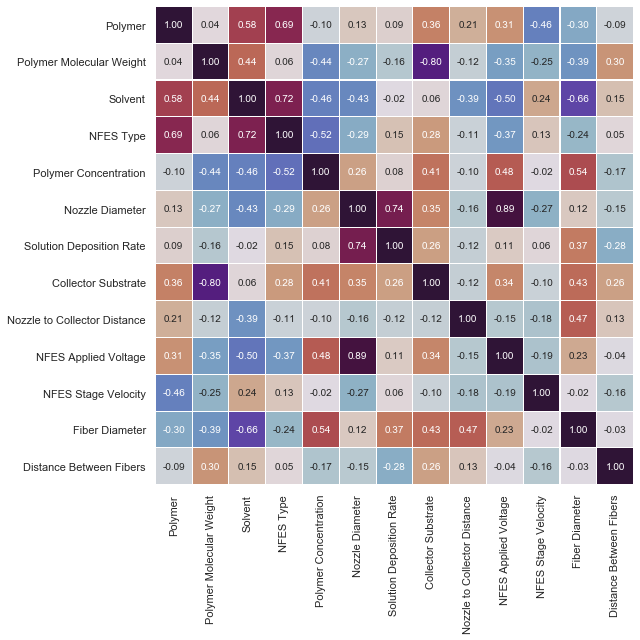

In [6]:
corrMatrix = df_x.drop([
    "Solvent Surface Tension",
    "Solvent Dielectric Constant",
    "Solvent Boiling Point",
    "Solvent Density",
    "Solvent Vapour Pressure",
    "Reference"
], axis=1).corr();
#scale = 12;
#pd.plotting.scatter_matrix(corrMatrix, alpha=0.5, figsize=(3*scale, 2*scale), s=scale*10);
#plt.show();

scale = 6;
#ax    = plt.figure(figsize=(5.5*scale, 1.5*scale));
ax    = plt.figure(figsize=(1.5*scale, 1.5*scale));
ax    = sns.heatmap(
    corrMatrix,              # provide dataFrame
    annot=True,              # show correlation coefficients
    fmt=".2f",               # correlation coefficients data type
    linewidths=0.1,          # spacing within cells
    cbar=False,              # show colour/coefficient bar
    cmap="twilight_shifted", # colour selection
    center=0.0               # center value
);
plt.tight_layout();
plt.savefig('plt_corMat.png');
plt.show();
mpl.rcParams.update(mpl.rcParamsDefault); # Recover matplotlib defaults

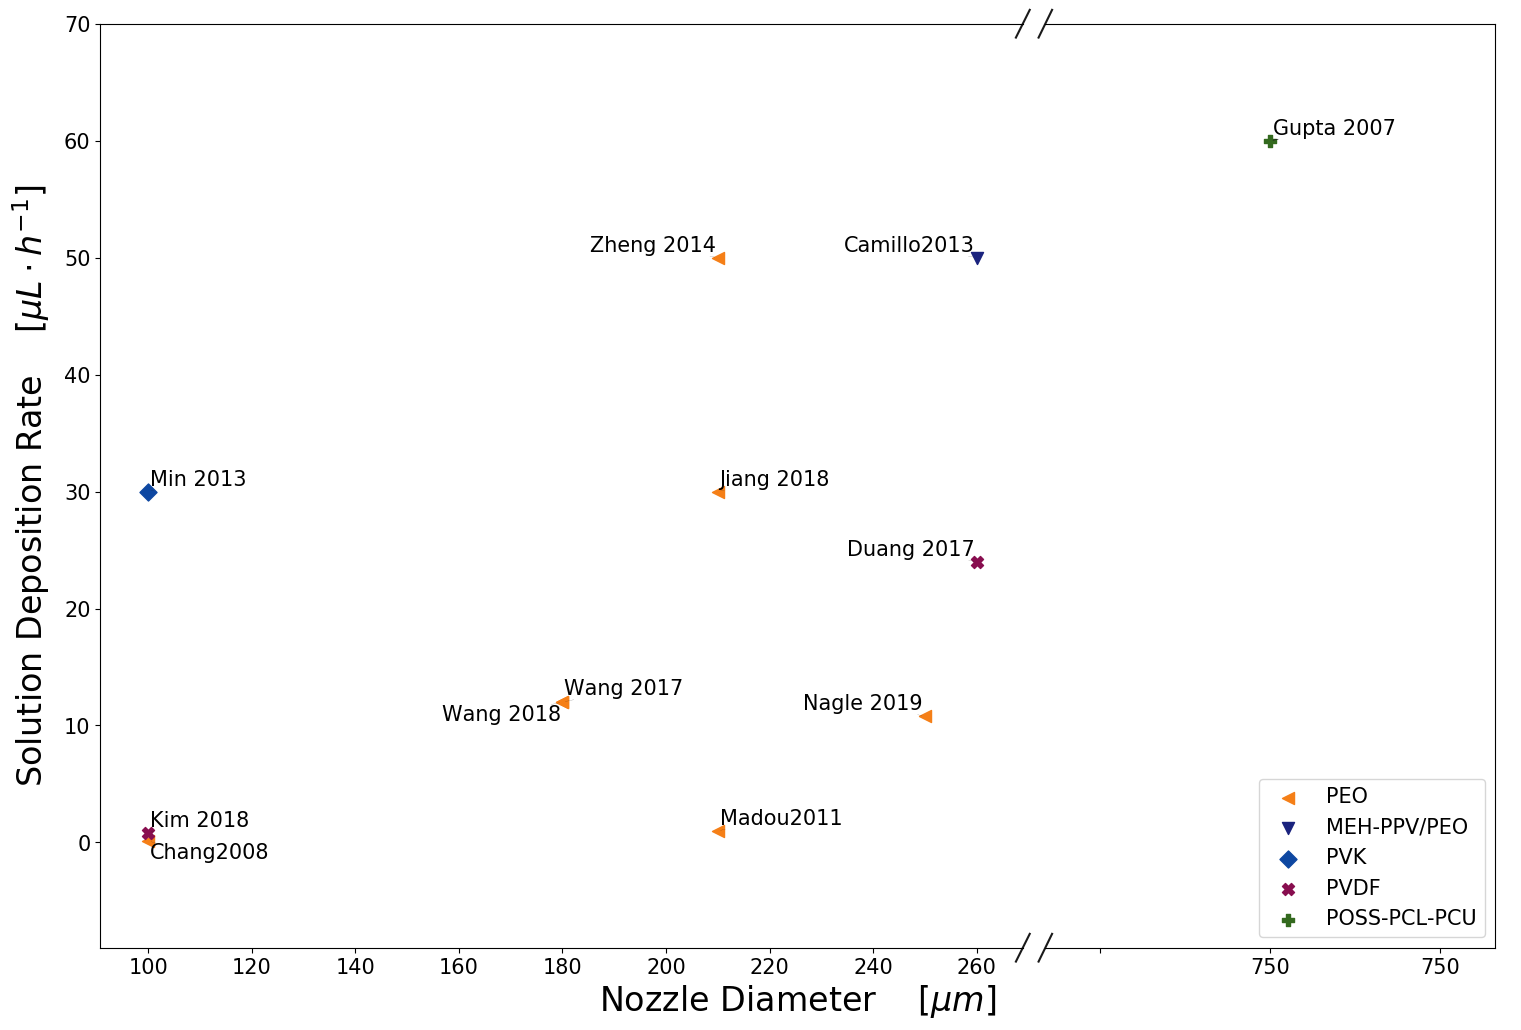

In [7]:
x_str = 'Nozzle Diameter'; x_units = r'$[\mu m]$';
y_str = 'Solution Deposition Rate'; y_units = r'$[\mu L \cdot h^{-1}]$';
breakXlim = 550;
breakYlim = None;
legPos = 'lower right';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

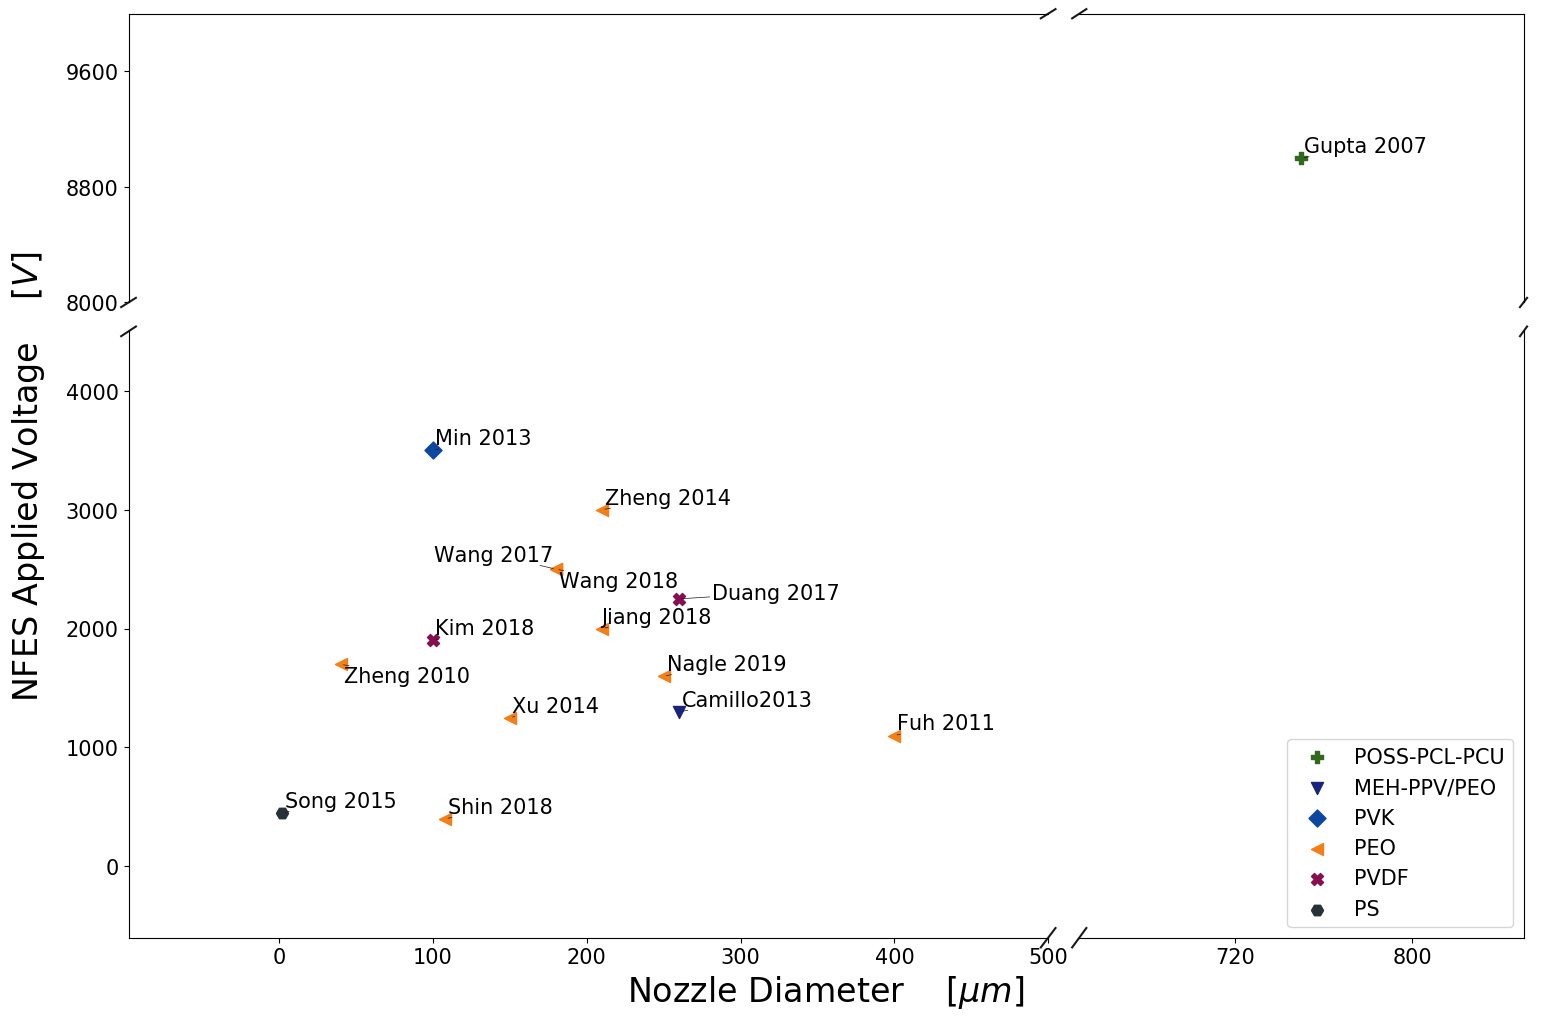

In [8]:
x_str = 'Nozzle Diameter'; x_units = r'$[\mu m]$';
y_str = 'NFES Applied Voltage'; y_units = r'$[V]$';
breakXlim = 550;
breakYlim = 6000;
legPos = 'lower right';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

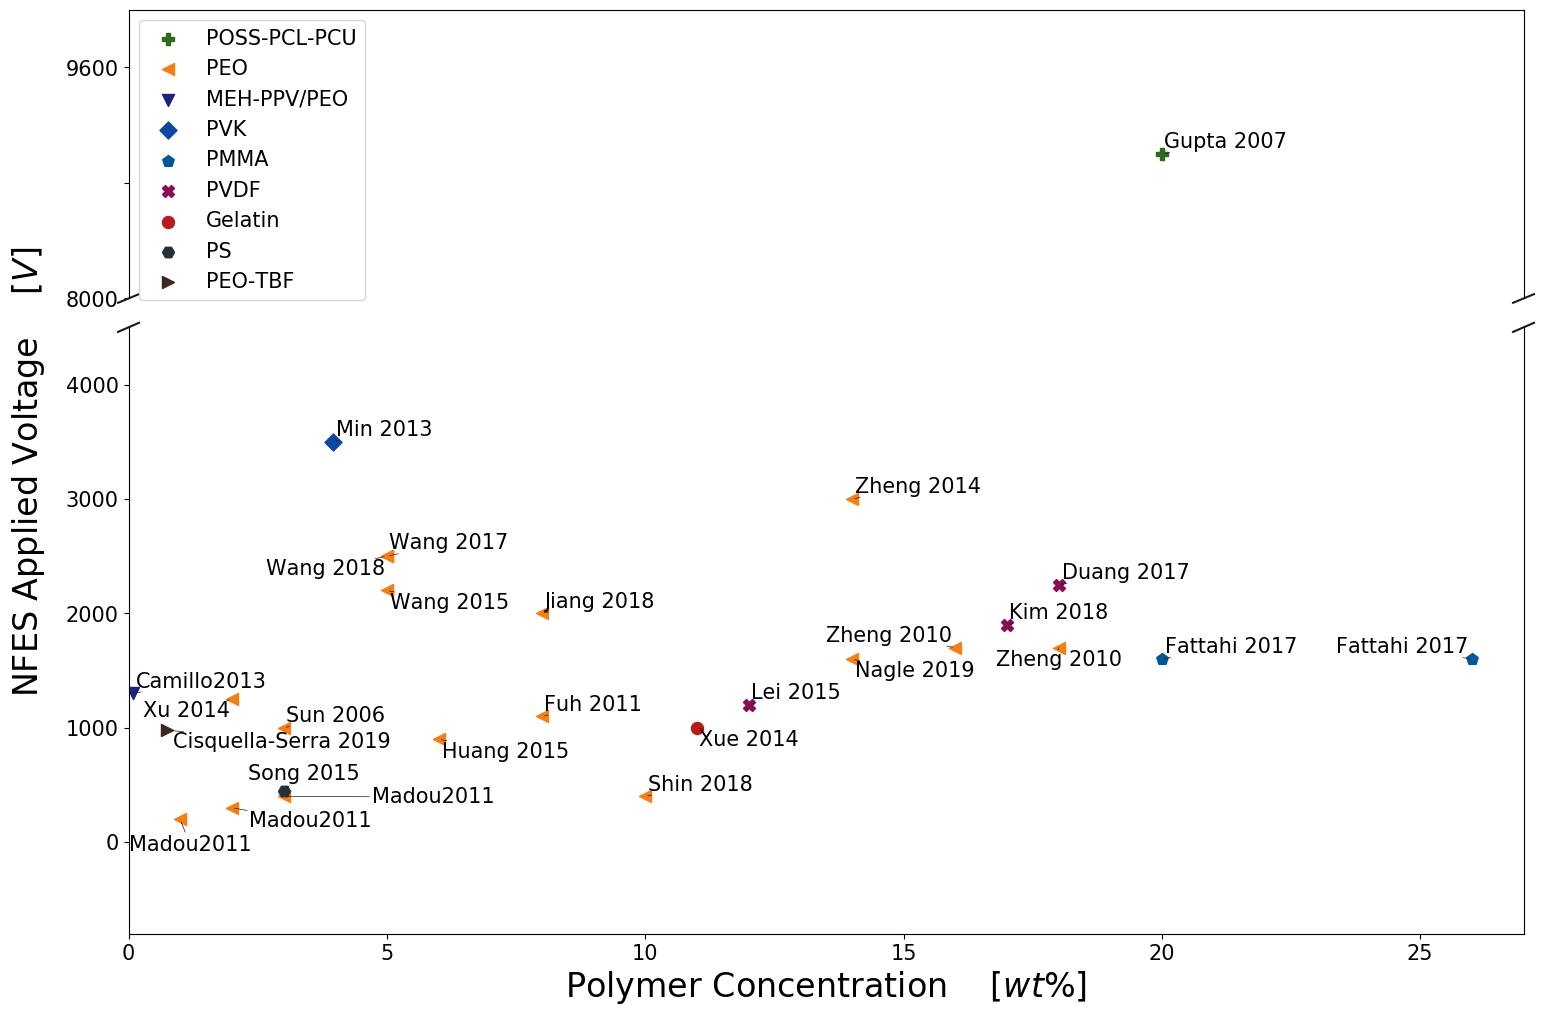

In [9]:
x_str = 'Polymer Concentration'; x_units = r'$[wt\%]$';
y_str = 'NFES Applied Voltage'; y_units = r'$[V]$';
breakXlim = None;
breakYlim = 6000;
legPos = 'upper left';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos); ###

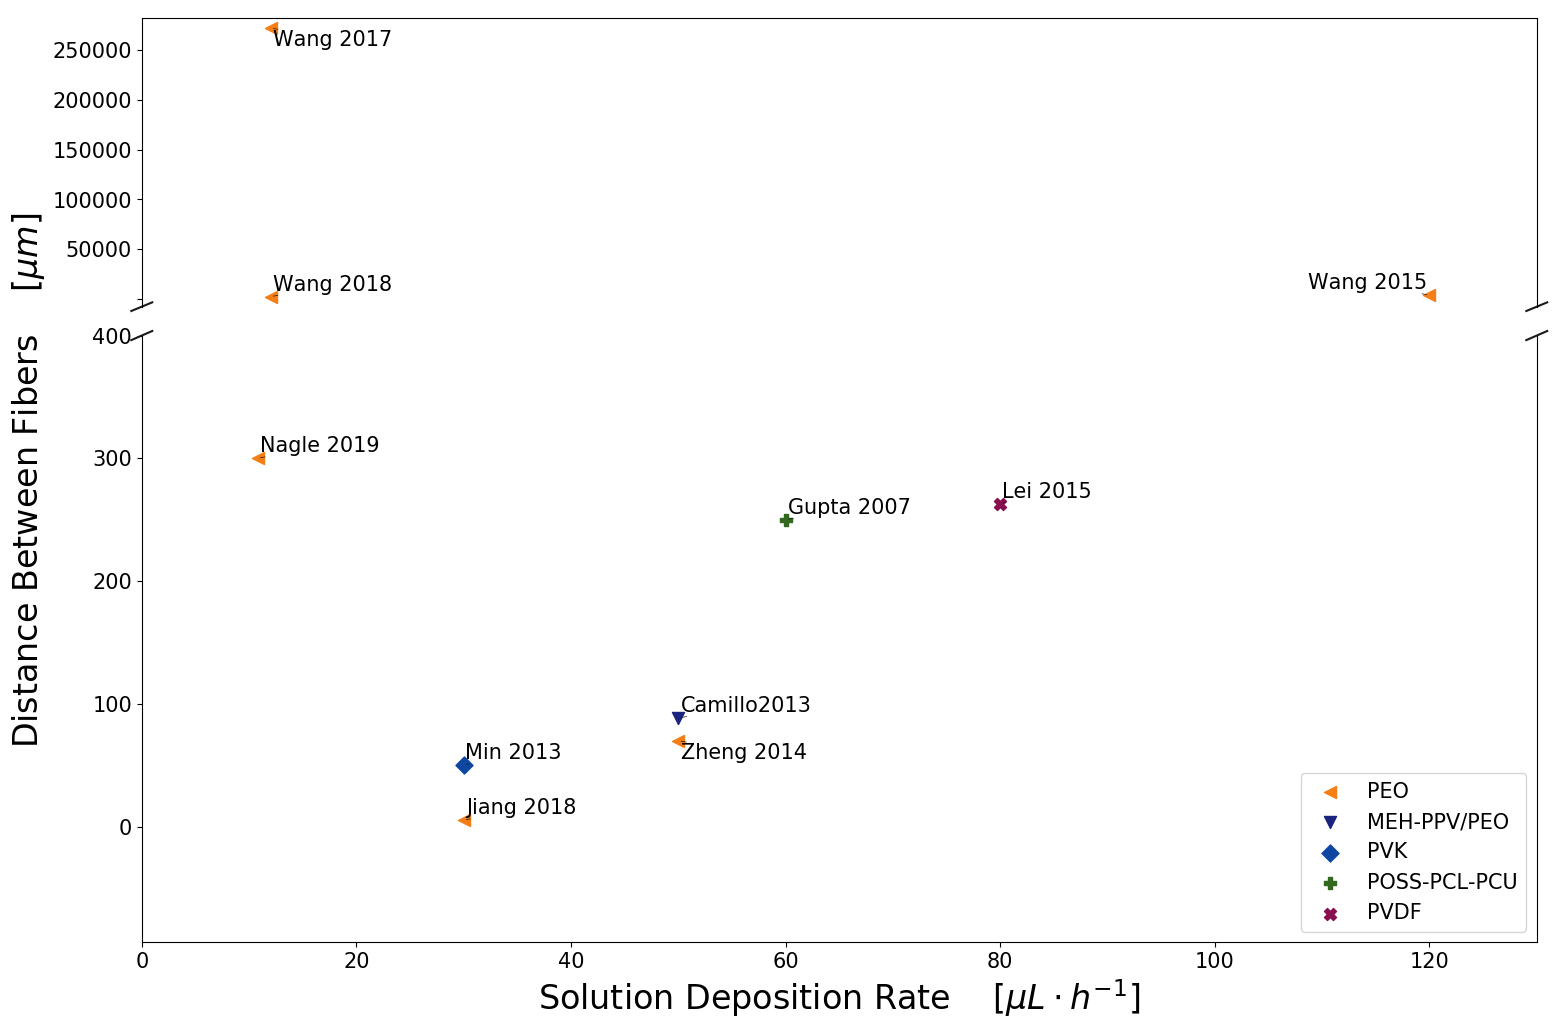

In [10]:
x_str = 'Solution Deposition Rate'; x_units = r'$[\mu L \cdot h^{-1}]$';
y_str = 'Distance Between Fibers'; y_units = r'$[\mu m]$';
breakXlim = None;
breakYlim = 1000;
legPos = 'lower right';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

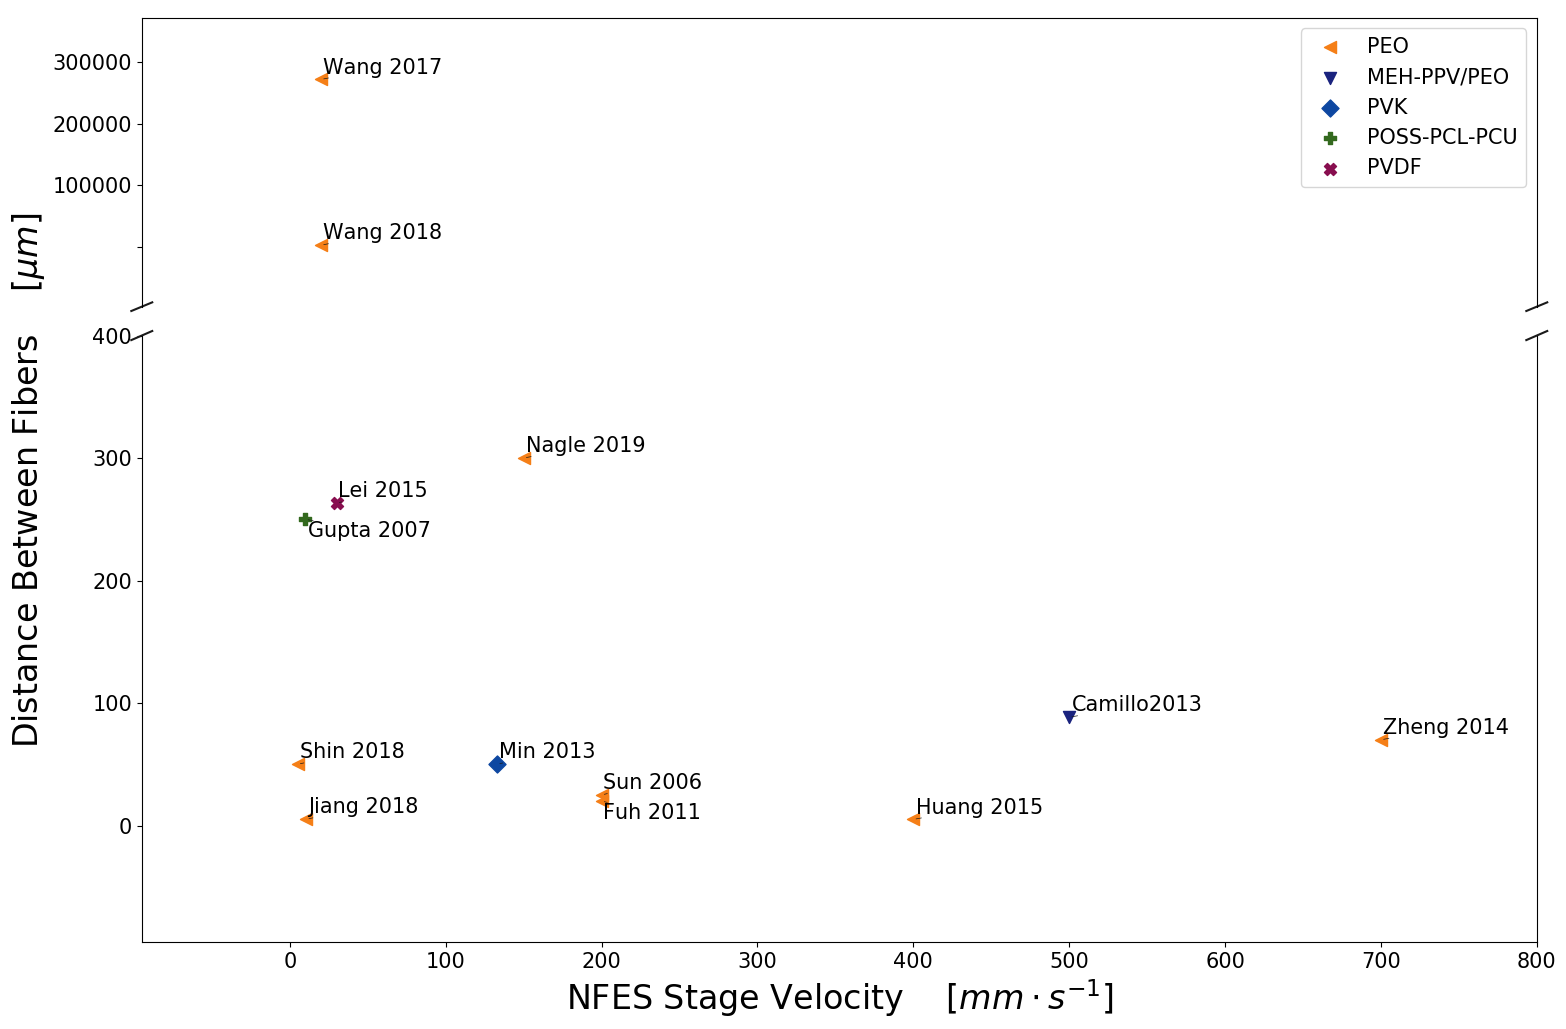

In [11]:
x_str = 'NFES Stage Velocity'; x_units = r'$[mm \cdot s^{-1}]$';
y_str = 'Distance Between Fibers'; y_units = r'$[\mu m]$';
breakXlim = None;
breakYlim = 1000;
legPos = 'upper right';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

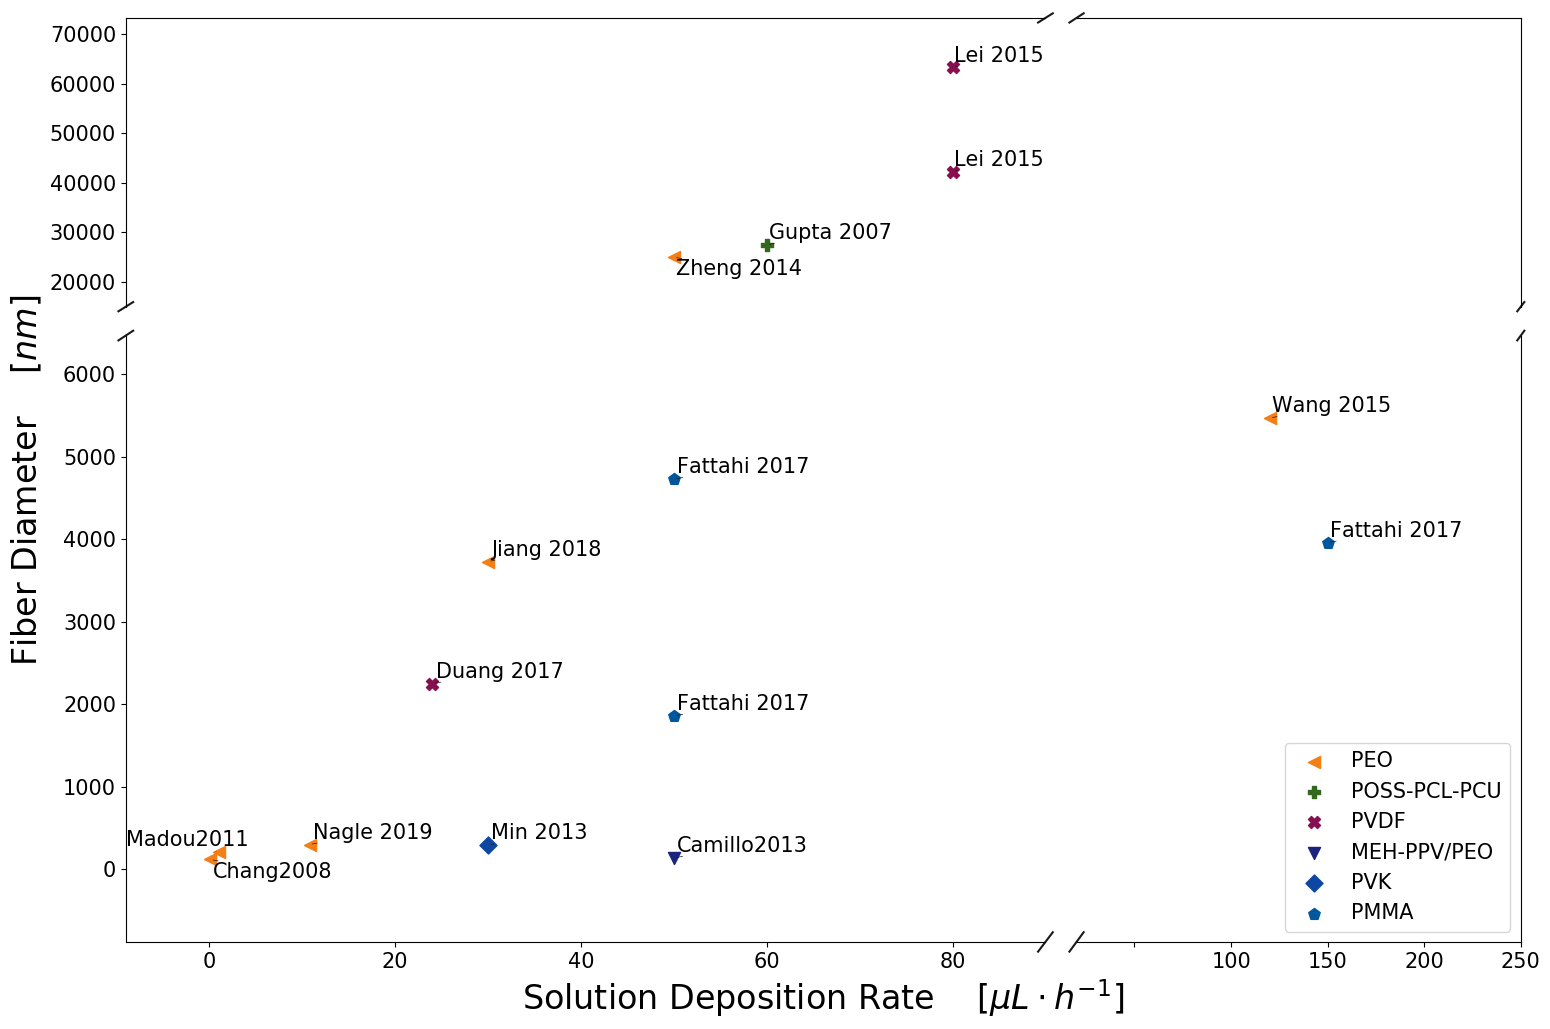

In [12]:
x_str = 'Solution Deposition Rate'; x_units = r'$[\mu L \cdot h^{-1}]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakXlim = 100;
breakYlim = 15000;
legPos = 'lower right';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

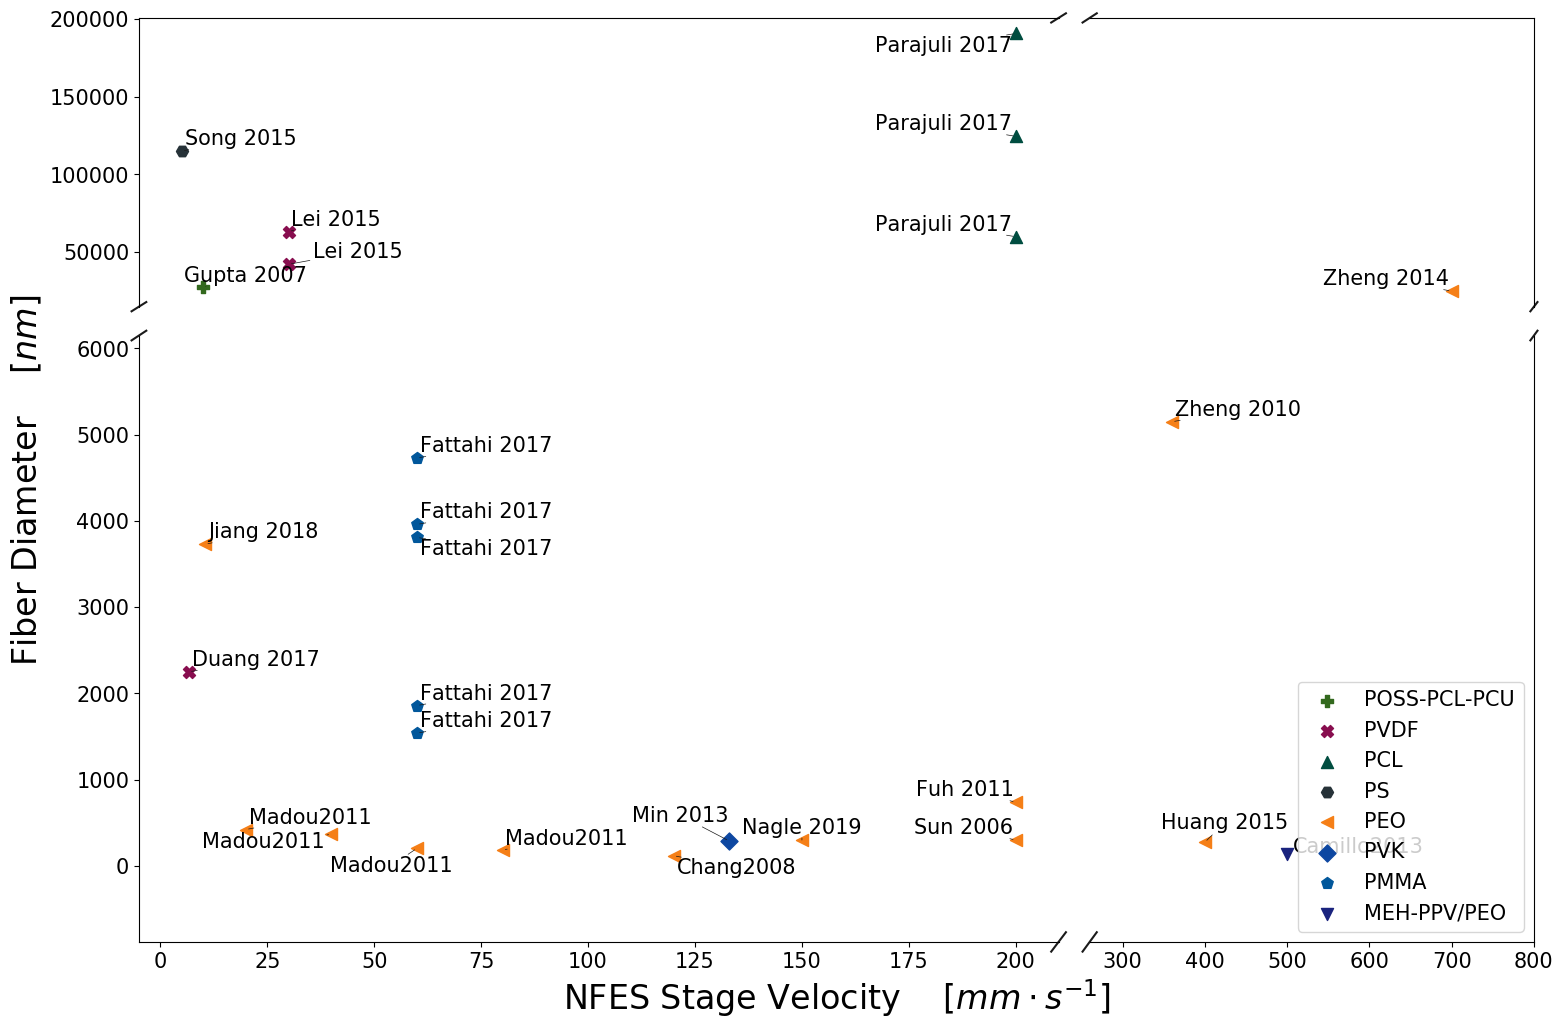

In [13]:
x_str = 'NFES Stage Velocity'; x_units = r'$[mm \cdot s^{-1}]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakXlim = 300;
breakYlim = 20000;
legPos = 'lower right';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

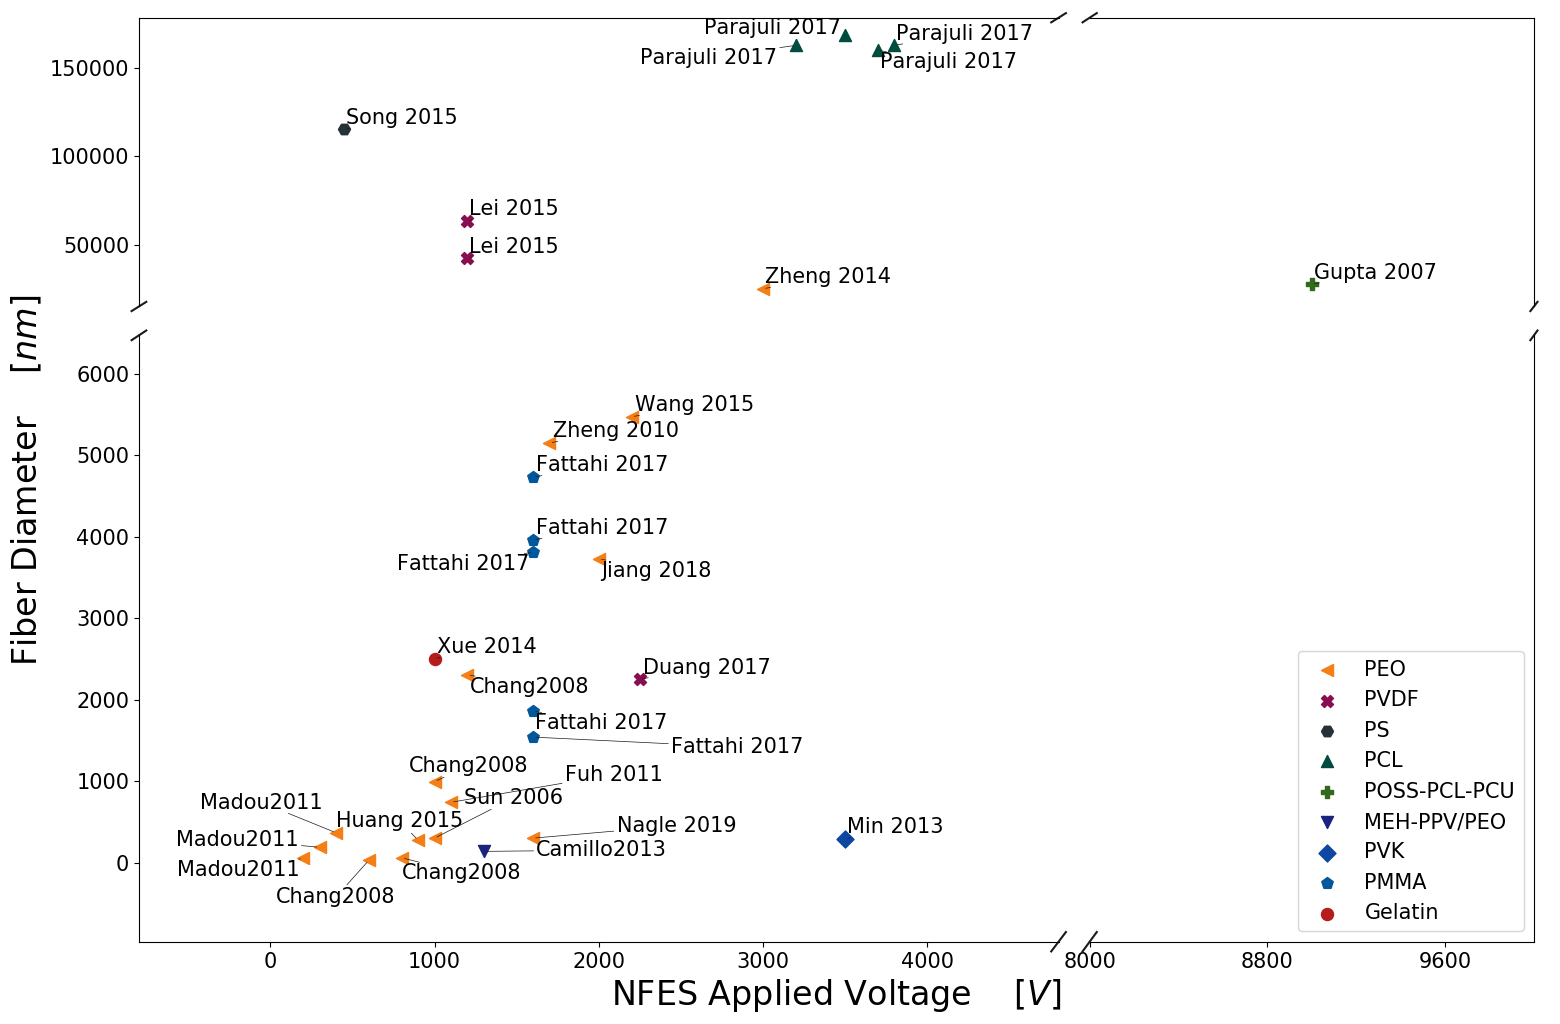

In [14]:
x_str = 'NFES Applied Voltage'; x_units = r'$[V]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakXlim = 6000;
breakYlim = 20000;
legPos = 'lower right';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

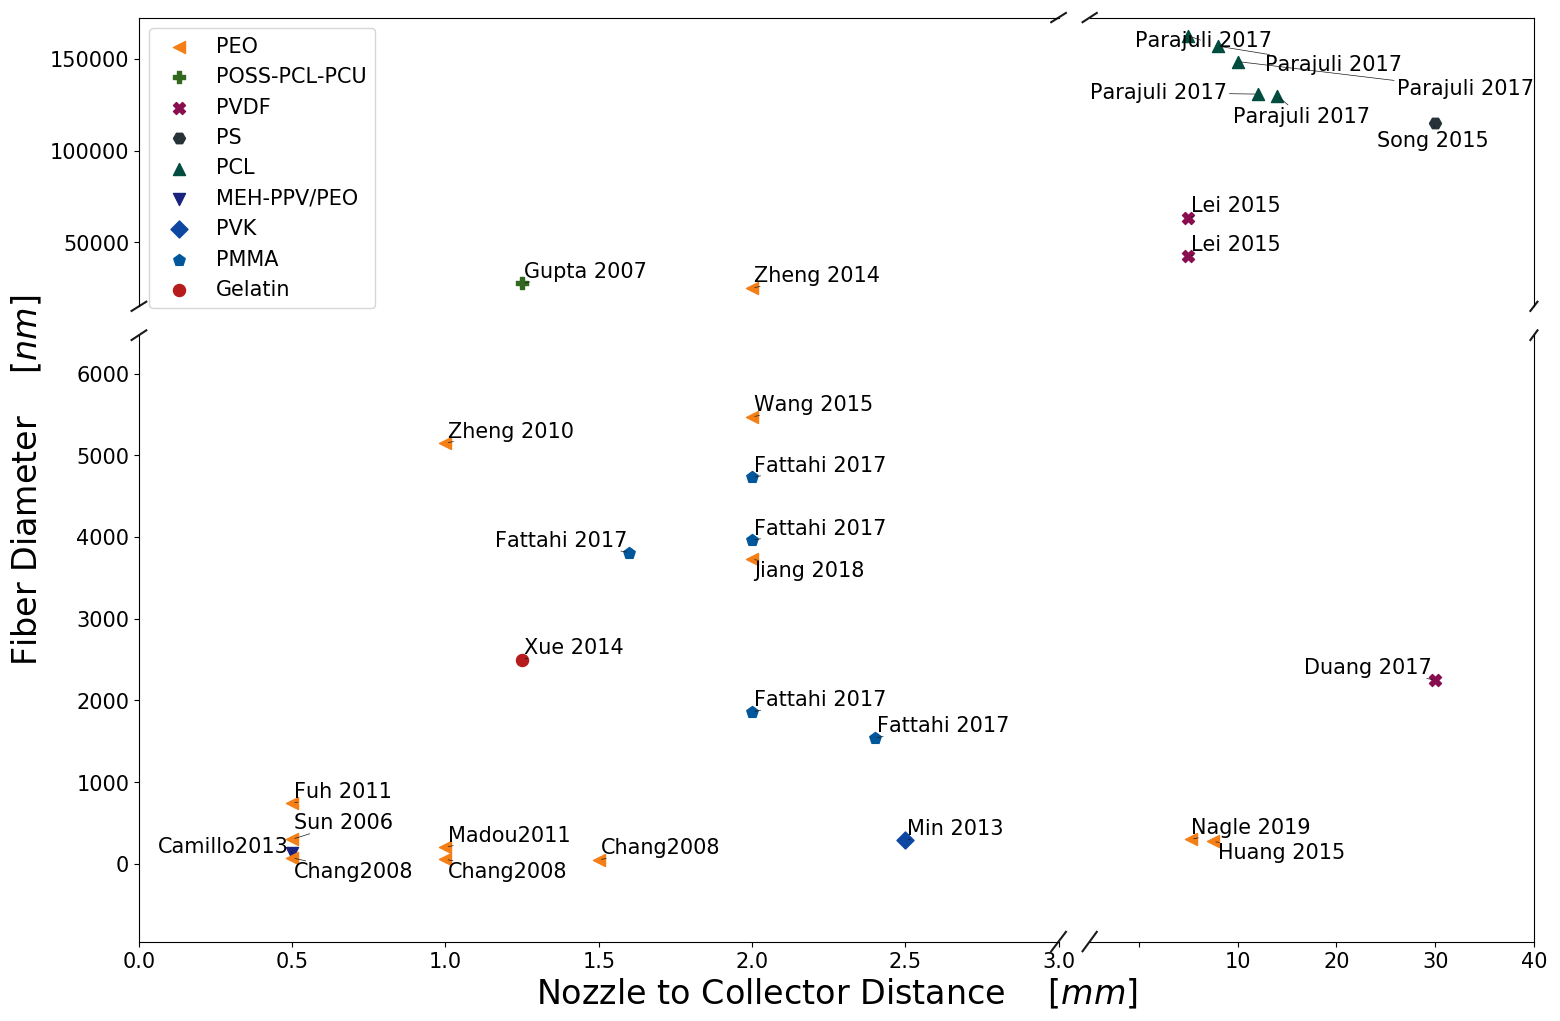

In [15]:
x_str = 'Nozzle to Collector Distance'; x_units = r'$[mm]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakXlim = 3;
breakYlim = 6000;
legPos = 'upper left';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

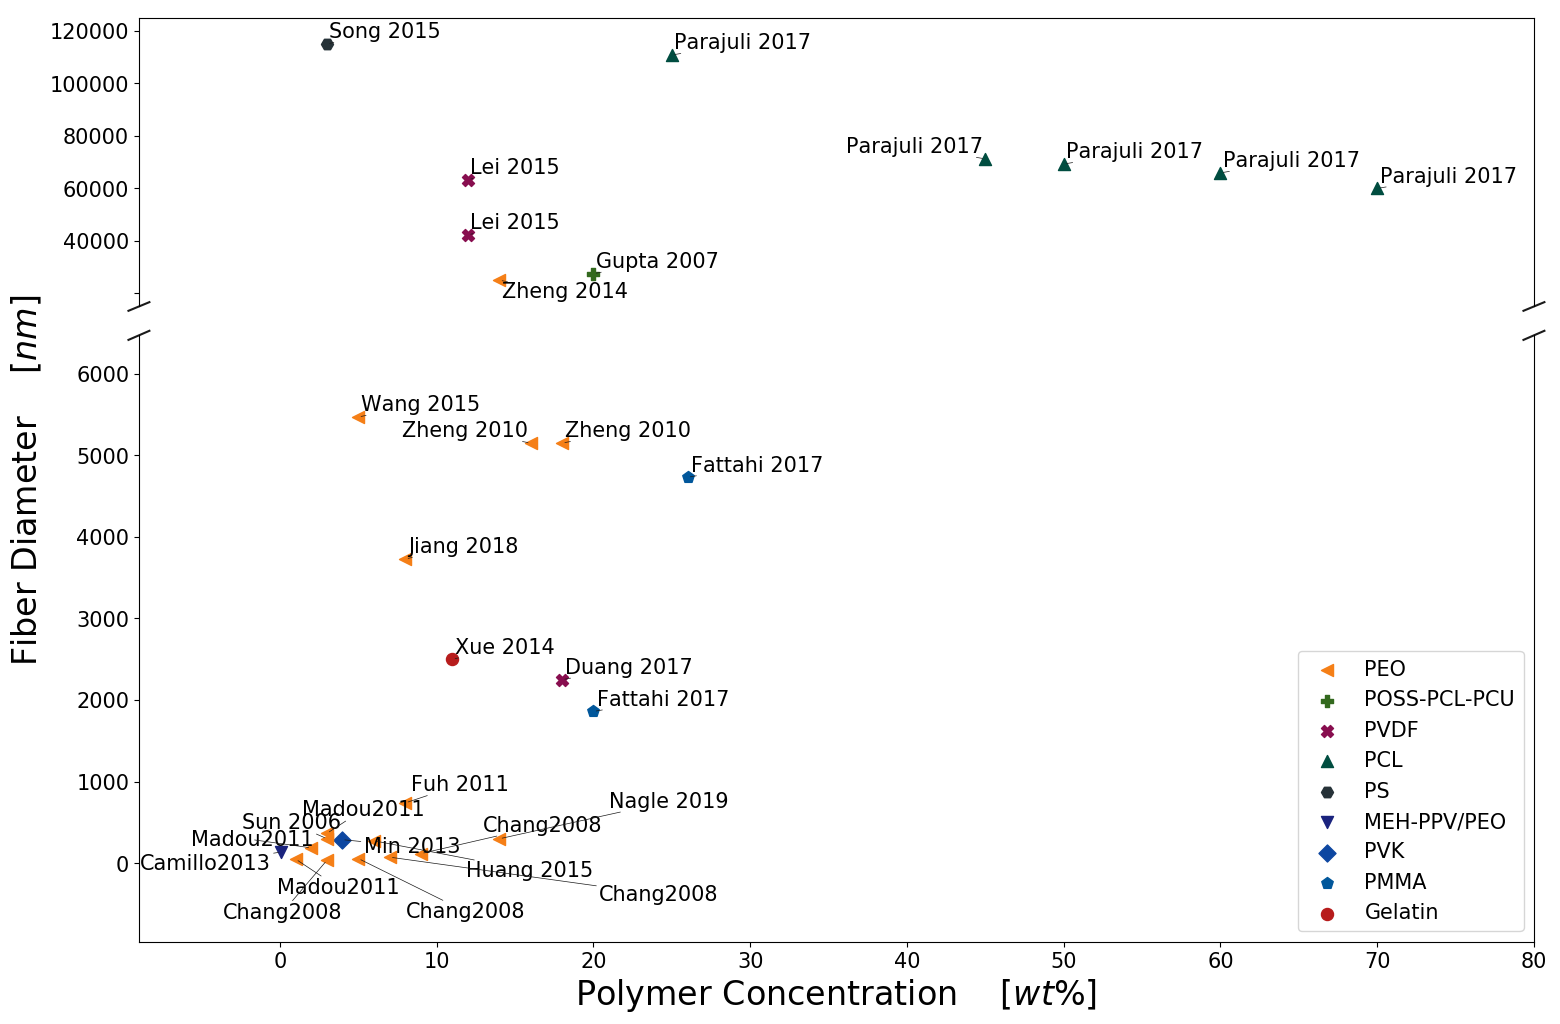

In [16]:
x_str = 'Polymer Concentration'; x_units = r'$[wt\%]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakXlim = None;
breakYlim = 6000;
legPos = 'lower right';
scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, breakXlim, breakYlim, legPos);

In [17]:
# import pdfkit
# path_wkthmltopdf = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe'
# config = pdfkit.configuration(wkhtmltopdf=path_wkthmltopdf)

# options = {
#     'page-size': 'A4',
#     'margin-top': '0.0in',
#     'margin-right': '0.0in',
#     'margin-bottom': '0.0in',
#     'margin-left': '0.0in',
#     'encoding': "UTF-8",
#     'custom-header' : [
#         ('Accept-Encoding', 'gzip')
#     ],
#     'cookie': [
#         ('cookie-name1', 'cookie-value1'),
#         ('cookie-name2', 'cookie-value2'),
#     ],
#     'no-outline': None,
#     'orientation': 'Landscape'
# }

# pdfkit.from_file('./NFES_ReviewPaper.html','NFES_ReviewPaper.pdf', configuration=config, options=options)